In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import copy

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...,NaN,NaN,NaN,NaN,NaN
1,R_pSlyunfdAKMG8EN,GEN_HF_6,High Fantasy,Genesis,SurveySwap,2.0,3.0,4.0,4,4.0,...,2022-02-21 01:10:19,2022-02-21 01:17:01,402,2022-02-21 07:20:12,Nothing seemed to be happening in the story.|T...,...the description of a small village.,...someone working in a tavern.|...a noise com...,2.0,True,True
2,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...,NaN,NaN,NaN,NaN,NaN


In [158]:
items_descr["tss_qua_1"]

'This story was enjoyable.'

In [159]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]


# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.739726
std       9.824894
min      30.000000
25%      43.000000
50%      53.000000
75%      57.000000
max      72.000000
dtype: float64


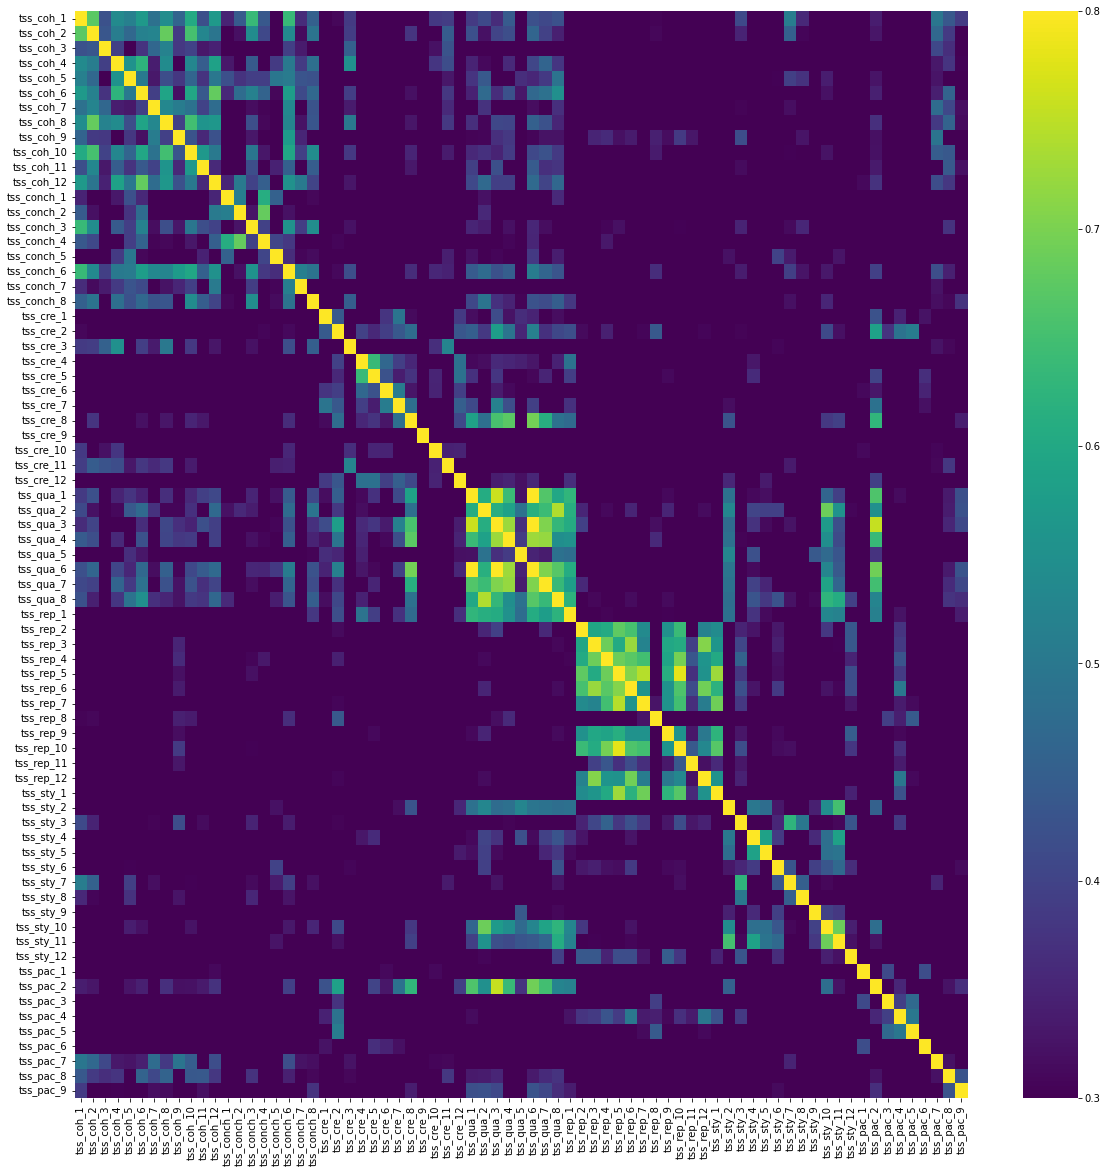

In [160]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [161]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_9", "tss_cre_10",
    "tss_rep_8",
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_9: The setting of the story was original.
Correlations >= .3:
NONE - ALL correlations are < .3!

tss_cre_10: The story was unconventional.
Correlations >= .3:
tss_coh_1      0.382967
tss_conch_6    0.353432
tss_cre_5      0.350034
tss_cre_6      0.348622
tss_cre_12     0.347838
tss_pac_1      0.310682
tss_pac_7      0.307485

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_coh_1      0.305456
tss_coh_2      0.307901
tss_coh_9      0.343524
tss_conch_6    0.362829
tss_cre_2      0.436931
tss_rep_7      0.326374
tss_pac_3      0.390912
tss_pac_4      0.341236
tss_pac_5      0.439510

tss_pac_1: The story moved at a fast pace.
Correlations >= .3:
tss_coh_12    0.311502
tss_cre_6     0.311259
tss_cre_10    0.310682
tss_pac_6     0.416006

tss_pac_3: It took a long time for things to happen in the story.
Correlations >= .3:
tss_cre_2    0.373357
tss_rep_8    0.390912
tss_pac_4    0.393304
tss_pac_5    0.468089

tss_pac_5: Nothing seemed to be happening in the story.


In [162]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)
items_analysis_li.remove("tss_cre_9")

In [163]:
# Check for multicollinearity
print("\nHigh pairs of correlation")
for entry in high_corr_li:
    print("{} <-> {}: {}".format(entry[0], entry[1], entry[2]))
items_corr = tss_df[items_analysis_li].corr()
print("\nDeterminant of correlation matrix: {}".format(np.linalg.det(items_corr)))

# Determinant should be > .00001


High pairs of correlation
tss_qua_1 <-> tss_qua_6: 0.8178152597760946
tss_qua_3 <-> tss_qua_6: 0.826733802224246
tss_qua_6 <-> tss_qua_1: 0.8178152597760946
tss_qua_6 <-> tss_qua_3: 0.826733802224246

Determinant of correlation matrix: 6.651171768303384e-30


In [164]:
# Disply item descriptions for items with high corr
high_corr_items = [
    "tss_qua_1", "tss_qua_3", "tss_qua_6"
]

for item in high_corr_items:
    print(item + ":")
    print(items_descr[item] + "\n")

tss_qua_1:
This story was enjoyable.

tss_qua_3:
The story was fun to read.

tss_qua_6:
I liked this story.



In [165]:
# Decide here whether to exclude items based on high correlations
# If determinant stays high can still you can work based on trial-and-error to see which variable to exclude
items_analysis_li.remove("tss_qua_6")

items_corr = tss_df[items_analysis_li].corr()
print("\nDeterminant of correlation matrix: {}".format(np.linalg.det(items_corr)))


Determinant of correlation matrix: 6.530398179227213e-29


In [166]:
# Check change of determinant when removing for each item
# Remove item with highest change
# Rinse and repeat until det is > .00001

best_det = np.linalg.det(items_corr)
remove_item = ""
items_removed = 0

while best_det < 0.00001:
    for item in items_analysis_li:
        new_item_li = copy.deepcopy(items_analysis_li)
        new_item_li.remove(item)
        new_corrs = tss_df[new_item_li].corr()
        new_det = np.linalg.det(new_corrs)

        if new_det > best_det:
            best_det = new_det
            remove_item = item

    items_analysis_li.remove(remove_item)
    items_removed += 1
    print("Removed item {} ('{}'). New determinant: {}".format(
        remove_item, items_descr[remove_item], best_det))

print("\nDONE! Current determinant is {:f}. Removed {} items. {} items remaining".format(
    best_det, items_removed, len(items_analysis_li)))

Removed item tss_qua_3 ('The story was fun to read.'). New determinant: 5.4706085244017615e-28
Removed item tss_coh_1 ('I had a hard time making sense of what was going on in the story.'). New determinant: 4.408136403887312e-27
Removed item tss_rep_5 ('In the story, the same things happened again and again.'). New determinant: 3.2721233541171505e-26
Removed item tss_rep_4 ('The story was very repetitive.'). New determinant: 2.2089013852411937e-25
Removed item tss_coh_2 ('I had a hard time recognizing the thread of the story.'). New determinant: 1.3867263882275194e-24
Removed item tss_qua_2 ('This story is of high quality.'). New determinant: 8.57716935106655e-24
Removed item tss_sty_11 ('The author's choice of words was elegant'). New determinant: 4.573094775261363e-23
Removed item tss_qua_7 ('I would like to read more stories like this one.'). New determinant: 2.3893846281841145e-22
Removed item tss_rep_3 ('Many sentences in the story had frequently repeated words and phrases.'). New 

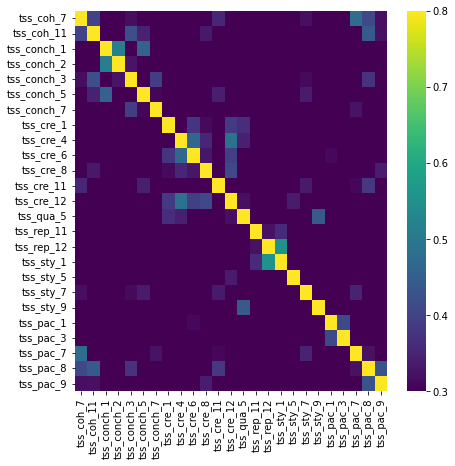

In [263]:
items_corr = tss_df[items_analysis_li].corr()

# Show heatmap for current absolute (!) correlation between items
fig, ax = plt.subplots(figsize=(7, 7))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin = 0.3, vmax = 0.8)

In [171]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=16, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.768165779829337
All item KMOs are >.6


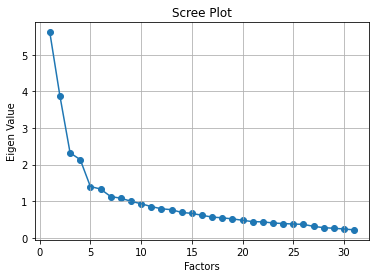

In [177]:
efa = fa.factor_analyzer.FactorAnalyzer(rotation = None, n_factors=tss_df[items_analysis_li].shape[1])
efa.fit(tss_df[items_analysis_li])
ev,_ = efa.get_eigenvalues()
plt.scatter(range(1,tss_df[items_analysis_li].shape[1]+1),ev)
plt.plot(range(1,tss_df[items_analysis_li].shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

In [259]:
efa = fa.FactorAnalyzer(n_factors=4,rotation='varimax')
efa.fit(tss_df[items_analysis_li])

comm = pd.DataFrame(efa.get_communalities(),index=tss_df[items_analysis_li].columns,columns=['Communalities'])
comm.sort_values("Communalities", ascending=False)

,Communalities
tss_rep_12,0.664334
tss_cre_12,0.490433
tss_pac_8,0.480734
tss_pac_1,0.458046
tss_coh_7,0.432813
tss_cre_6,0.425290
tss_sty_1,0.418521
tss_qua_5,0.414594
tss_pac_3,0.404254
tss_pac_7,0.402757


In [260]:
efa.rotation_matrix_

array([[ 0.84385341,  0.45015965, -0.26388026, -0.12503967],
       [-0.44516004,  0.84702851, -0.10662776,  0.27019578],
       [ 0.20771225,  0.19707984,  0.9528539 ,  0.1004221 ],
       [ 0.21586935, -0.20262906, -0.10520062,  0.9493549 ]])

In [261]:
loadings = pd.DataFrame(efa.loadings_,index=tss_df[items_analysis_li].columns)
loadings["descr"] = loadings.apply(lambda x: items_descr[x.name], axis = 1)

loadings.sort_values(0, key=abs, ascending = False)

,0,1,2,3,descr
tss_pac_8,0.661865,0.049494,0.060829,0.191097,All elements of the story were relevant to the...
tss_coh_7,-0.626446,0.074403,0.175951,0.062323,The story felt like it contained a bunch of ju...
tss_coh_11,0.596403,0.124203,0.028893,-0.004407,The story had a clear theme.
tss_conch_3,-0.576207,-0.004718,0.260590,-0.035398,My understanding of the characters in the stor...
tss_pac_7,-0.555943,0.189957,0.110393,0.213105,Many things seemed to be happening at once in ...
tss_cre_11,0.527142,-0.088361,-0.025245,-0.080006,The plot was typical for this kind of story.
tss_sty_7,0.502574,0.099043,-0.167314,0.056211,The text was easy to understand.
tss_conch_1,0.498057,0.218981,0.182643,-0.233331,Descriptions of characters in the story were c...
tss_conch_5,0.492330,0.246514,0.034468,-0.181837,The descriptions of characters in the story we...
tss_conch_2,-0.481376,-0.153698,0.048281,0.189096,Characters in the story were described in a co...


In [235]:
mask_good_item = ((abs(loadings[[0,1,2,3]]) >= .32).astype(int).sum(axis=1)) == 1
items_analysis_li = mask_good_item[mask_good_item].index

# rinse and repeat...